## Import Libraries

In [ ]:
import os
import warnings

import scipy as sp
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import dateutil.relativedelta

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, roc_auc_score
from sklearn import metrics

import xgboost as xgb

from google.colab import drive

In [ ]:
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
%matplotlib inline

In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
RANDOM_STATE = 42

## Load Data

In [ ]:
DATA_PATH = "gdrive/MyDrive/EASY_MONEY_NUCLIO/data/"

In [ ]:
df_segmented = pd.read_pickle(DATA_PATH + "total_df_segmentado.pkl")

In [ ]:
df = pd.read_csv(DATA_PATH + "total_df.csv", sep=";", index_col=0)

In [ ]:
# corregir fechas
df.loc[df["entry_date"] == "2015-02-29", "entry_date"] = "2015-02-28"
df.loc[df["entry_date"] == "2019-02-29", "entry_date"] = "2019-02-28"

In [ ]:
DATES = df["pk_partition"].unique().tolist()

In [ ]:
df["pk_partition"] = pd.to_datetime(df["pk_partition"], format="%Y-%m-%d")
df["entry_date"] = pd.to_datetime(df["entry_date"], format="%Y-%m-%d")

In [ ]:
PRODUCTS = [
    "short_term_deposit",	
    "loans",
    "mortgage",	
    "funds",
    "securities",
    "long_term_deposit",	
    "em_account_pp",	
    "credit_card",	
    "payroll",	
    "pension_plan",	
    "payroll_account",	
    "emc_account",	
    "debit_card",	
    "em_account_p",	
    "em_acount"	
]

PRICE = {
    "Finaciación": 60,
    "Ahorro/Inversion": 40,
    "Cuentas": 10
}

PRODUCTS_PRICED = {
    "short_term_deposit": "Ahorro/Inversion",	
    "loans": "Finaciación",
    "mortgage": "Finaciación",	
    "funds": "Ahorro/Inversion",
    "securities": "Ahorro/Inversion",
    "long_term_deposit": "Ahorro/Inversion",	
    "em_account_pp": "Cuentas",	
    "credit_card": "Finaciación",
    "pension_plan": "Ahorro/Inversion",	
    "payroll_account": "Cuentas",	
    "emc_account": "Cuentas",	
    "debit_card": "Finaciación",	
    "em_account_p": "Cuentas",	
    "em_acount": "Cuentas"	
}

# EDA

In [ ]:
df.isna().sum()

pk_cid                      0
pk_partition                0
short_term_deposit          0
loans                       0
mortgage                    0
funds                       0
securities                  0
long_term_deposit           0
em_account_pp               0
credit_card                 0
payroll                    61
pension_plan               61
payroll_account             0
emc_account                 0
debit_card                  0
em_account_p                0
em_acount                   0
entry_date                  0
entry_channel          133033
active_customer             0
segment                133944
country_id                  0
region_code              2264
gender                     25
age                         0
deceased                    0
salary                1512103
dtype: int64

In [ ]:
df[["pk_cid", "pk_partition"]].duplicated().astype(int).sum()

0

# NaN's

In [ ]:
df["salary"] = df["salary"].fillna(-9999)

In [ ]:
df["region_code"] = df["region_code"].fillna(-99)

In [ ]:
df["entry_channel"] = df["entry_channel"].fillna("Unknown")

In [ ]:
df["pension_plan"].value_counts(dropna=False)

0.0    5745061
1.0     217802
NaN         61
Name: pension_plan, dtype: int64

In [ ]:
df["pension_plan"] = df["pension_plan"].fillna(0.0)

In [ ]:
df["gender"].value_counts(dropna=False)

H      3087502
V      2875397
NaN         25
Name: gender, dtype: int64

In [ ]:
df["gender"] = df["gender"].fillna(df["gender"].mode().values[0])

In [ ]:
df.isna().sum()

pk_cid                     0
pk_partition               0
short_term_deposit         0
loans                      0
mortgage                   0
funds                      0
securities                 0
long_term_deposit          0
em_account_pp              0
credit_card                0
payroll                   61
pension_plan               0
payroll_account            0
emc_account                0
debit_card                 0
em_account_p               0
em_acount                  0
entry_date                 0
entry_channel              0
active_customer            0
segment               133944
country_id                 0
region_code                0
gender                     0
age                        0
deceased                   0
salary                     0
dtype: int64

# Population Analysis

In [ ]:
for product in PRODUCTS:
  if product not in ["payroll", "em_account_pp"]:
    print(f"#########{product}########")
    print(df.loc[df[product] == 1, [product, "age", "salary"]].describe())
    print("Predominant gender: ", df.loc[df[product] == 1, "gender"].mode().values[0])
    print("#####################")
    print("")

#########short_term_deposit########
       short_term_deposit           age        salary
count             15394.0  15394.000000  1.539400e+04
mean                  1.0     46.836690  9.187965e+04
std                   0.0     13.849793  1.914814e+05
min                   1.0     20.000000 -9.999000e+03
25%                   1.0     37.000000 -9.999000e+03
50%                   1.0     44.000000  8.017053e+04
75%                   1.0     55.000000  1.269798e+05
max                   1.0     97.000000  9.833873e+06
Predominant gender:  V
#####################

#########loans########
       loans         age         salary
count  468.0  468.000000     468.000000
mean     1.0   33.478632   95258.656923
std      0.0    9.633630   61072.220811
min      1.0   21.000000   -9999.000000
25%      1.0   26.000000   60530.880000
50%      1.0   30.000000   78374.385000
75%      1.0   37.250000  145972.320000
max      1.0   60.000000  228200.220000
Predominant gender:  V
#####################

###

Podemos observar como algunos productos se podrían agrupar debido a que el perfil de edad de los clientes es parecido. La variable "salary" no es un buen indicativo del cliente (se extrayeron los datos a partir de encuestas) para hacer esta agrupación.

In [ ]:
for product in PRODUCTS:
  if product != "payroll":
    _df = df.groupby("pk_cid").agg({product: "max"})
    print(f"#######{product}#######")
    print(_df[product].value_counts())
    print(_df[product].value_counts(normalize=True))
    print("########################")
    print("")

del _df

#######short_term_deposit#######
0    451049
1      5324
Name: short_term_deposit, dtype: int64
0    0.988334
1    0.011666
Name: short_term_deposit, dtype: float64
########################

#######loans#######
0    456329
1        44
Name: loans, dtype: int64
0    0.999904
1    0.000096
Name: loans, dtype: float64
########################

#######mortgage#######
0    456348
1        25
Name: mortgage, dtype: int64
0    0.999945
1    0.000055
Name: mortgage, dtype: float64
########################

#######funds#######
0    454707
1      1666
Name: funds, dtype: int64
0    0.996349
1    0.003651
Name: funds, dtype: float64
########################

#######securities#######
0    454284
1      2089
Name: securities, dtype: int64
0    0.995423
1    0.004577
Name: securities, dtype: float64
########################

#######long_term_deposit#######
0    447262
1      9111
Name: long_term_deposit, dtype: int64
0    0.980036
1    0.019964
Name: long_term_deposit, dtype: float64
###############

Podemos ver como la tenencia de los distintos productos no esta balanceada en la gran mayoría de los casos.

También se puede observar como el producto em_account_pp no tiene ninguna venta en todo el histórico disponible.

Un buen enfoque para atacar este problema sería agrupar los productos en distintas categorías en función de lo parecida que sea la población que contrata cada producto, como de balanceado este el target (cada producto) y por productos similares.

In [ ]:
cuentas = ["emc_account", "em_account_p", "payroll_account"]
ahorro_inversion = ["short_term_deposit", "long_term_deposit", "pension_plan", "securities", "funds"]
financiacion = ["credit_card", "mortgage", "loans"]

In [ ]:
df["cuentas"] = df[cuentas].max(axis=1)
df["ahorro_inversion"] = df[ahorro_inversion].max(axis=1)
df["financiacion"] = df[financiacion].max(axis=1)

for group in [cuentas, ahorro_inversion, financiacion]:
  df = df.drop(group, axis=1)

In [ ]:
for product in ["cuentas", "ahorro_inversion", "financiacion", "em_acount", "debit_card"]:
    _df = df.groupby("pk_cid").agg({product: "max"})
    print(f"#######{product}#######")
    print(_df[product].value_counts())
    print(_df[product].value_counts(normalize=True))
    print("########################")
    print("")
  
del _df

#######cuentas#######
0    403699
1     52674
Name: cuentas, dtype: int64
0    0.884581
1    0.115419
Name: cuentas, dtype: float64
########################

#######ahorro_inversion#######
0.0    413955
1.0     42418
Name: ahorro_inversion, dtype: int64
0.0    0.907054
1.0    0.092946
Name: ahorro_inversion, dtype: float64
########################

#######financiacion#######
0    447810
1      8563
Name: financiacion, dtype: int64
0    0.981237
1    0.018763
Name: financiacion, dtype: float64
########################

#######em_acount#######
1    332728
0    123645
Name: em_acount, dtype: int64
1    0.72907
0    0.27093
Name: em_acount, dtype: float64
########################

#######debit_card#######
0    392837
1     63536
Name: debit_card, dtype: int64
0    0.860781
1    0.139219
Name: debit_card, dtype: float64
########################



Podemos ver como todos los nuevos productos estan balanceados excepto los productos de "financiacion". Para esta categoría de productos tendremos que realizar técnicas de rebalanceo.

In [ ]:
df.head()

,pk_cid,pk_partition,em_account_pp,payroll,debit_card,em_acount,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary,cuentas,ahorro_inversion,financiacion
0,1375586,2018-01-28,0,0.0,0,1,2018-01-12,KHL,1.0,02 - PARTICULARES,ES,29.0,H,35,N,87218.10,0,0.0,0
1,1050611,2018-01-28,0,0.0,0,1,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,ES,13.0,V,23,N,35548.74,0,0.0,0
2,1050612,2018-01-28,0,0.0,0,1,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,ES,13.0,V,23,N,122179.11,0,0.0,0
3,1050613,2018-01-28,0,0.0,0,0,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,ES,50.0,H,22,N,119775.54,0,1.0,0
4,1050614,2018-01-28,0,0.0,0,1,2015-08-10,KHE,1.0,03 - UNIVERSITARIO,ES,50.0,V,23,N,-9999.00,0,0.0,0


# Preprocessing

In [ ]:
df["deceased"].value_counts()

N    5961849
S       1075
Name: deceased, dtype: int64

No podemos recomendar productos a clientes que estan muertos, por tanto, filtramos estos clientes.

In [ ]:
df = df[df["deceased"] != "S"]

In [ ]:
df = df[(df["age"] >= 18) & (df["age"] <= 90)]

In [ ]:
cols_to_drop = ["segment", "deceased", "payroll", "em_account_pp"]
df = df.drop(cols_to_drop, axis=1)

In [ ]:
print(df.shape)
print(df.columns)

(5921197, 15)
Index(['pk_cid', 'pk_partition', 'debit_card', 'em_acount', 'entry_date',
       'entry_channel', 'active_customer', 'country_id', 'region_code',
       'gender', 'age', 'salary', 'cuentas', 'ahorro_inversion',
       'financiacion'],
      dtype='object')


In [ ]:
df["country_id"] = LabelEncoder().fit_transform(df["country_id"])

In [ ]:
df["year"] = df["pk_partition"].dt.year
df["month"] = df["pk_partition"].dt.month

# eliminaremos esta columna posteriormente

In [ ]:
df["entry_year"] = df["entry_date"].dt.year
df["entry_month"] = df["entry_date"].dt.month
df["entry_day"] = df["entry_date"].dt.day
df["entry_week"] = df["entry_date"].dt.week
df["entry_weekday"] = df["entry_date"].dt.weekday
df["entry_quarter"] = df["entry_date"].dt.quarter

df = df.drop("entry_date", axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5921197 entries, 0 to 5962923
Data columns (total 22 columns):
 #   Column            Dtype         
---  ------            -----         
 0   pk_cid            int64         
 1   pk_partition      datetime64[ns]
 2   debit_card        int64         
 3   em_acount         int64         
 4   entry_channel     object        
 5   active_customer   float64       
 6   country_id        int64         
 7   region_code       float64       
 8   gender            object        
 9   age               int64         
 10  salary            float64       
 11  cuentas           int64         
 12  ahorro_inversion  float64       
 13  financiacion      int64         
 14  year              int64         
 15  month             int64         
 16  entry_year        int64         
 17  entry_month       int64         
 18  entry_day         int64         
 19  entry_week        int64         
 20  entry_weekday     int64         
 21  entry_qu

In [ ]:
def set_others(df, col, n):
    """
    Converts to Categorical column and sets Others for the categories outside the top n
    :param df: DataFrame object
    :param col: column name
    :param n: top X
    :return 
    """
    top_categories = df[col].value_counts().head(n)
    top_categories_list = top_categories.index.tolist()
    top_categories_list.append("Others")

    df[col] = pd.Categorical(df[col], categories=top_categories_list)
    return df[col].fillna("Others")

In [ ]:
df["entry_channel"].value_counts().head(8)

KHE        3113575
KFC         873049
KHQ         590224
KAT         405973
KHK         229826
KHM         176333
Unknown     132171
KHN         108157
Name: entry_channel, dtype: int64

In [ ]:
df["entry_channel"] = set_others(df, "entry_channel", 8)

In [ ]:
def one_hot_encoder(data, col):
    _dummy_dataset = pd.get_dummies(data[col], prefix=col)
    data = pd.concat([data, _dummy_dataset], axis=1)
    del data[col]
    del _dummy_dataset

    return data

In [ ]:
df = one_hot_encoder(df, "entry_channel")

In [ ]:
# region_code frequency encoding
region_counter = df["region_code"].value_counts(dropna=False)
df["region_code"] = df["region_code"].replace(region_counter)

In [ ]:
df["gender"] = (df["gender"] == "H").astype(int)

# Dataset Resampling

Queremos predecir las compras de los productos para el mes de Junio del 2019. Para poder implementar esto correctamente tendremos que coger los datos para "train/test" desde Febrero del 2018 hasta Abril del 2019 y nos guardaremos Mayo del 2019 para validación.

Una vez convertidos los datos para que el modelo los entienda, tendremos que preparar el conjunto de datos para que cada row represente a un cliente. 

Para realizar esto, se extraerá la fecha mínima de compra de cada cliente, le restaremos un mes a esa fecha y extraeremos la row correspondiente que contenga dicha fecha para cada cliente. Esto se realiza para conseguir la información de aquellos clientes a mes m1, ya que son los clientes que van a comprar el mes siguiente.

Con tal de que el modelo no aprenda a predecir mejor las compras en aquellos meses donde hay más predominancia de compras vs. no compras, realizaremos un rebalanceo mes a mes. El objetivo es conseguir un ratio de 90-10 de la clase negativa vs. la clase positiva.

In [ ]:
TARGETS = [
         "em_acount",
         "debit_card",
         "cuentas",
         "ahorro_inversion",
         "financiacion"
]

In [ ]:
def get_compras(df, target):
  compras = df[(df[target] == 1) & (df["pk_partition"] != "2018-01-28")].groupby("pk_cid")["pk_partition"].min().reset_index().set_index("pk_cid")
  compras["mes_m1"] = compras["pk_partition"].dt.date - pd.DateOffset(months=1)
  del compras["pk_partition"]
  compras.columns = ["pk_partition"]
  compras["compra"] = 1

  return compras

def clean_compras(df_compras, df):
  df_compras["pk_cid"] = df_compras.index
  c_cid_partition_tupled = df_compras[["pk_cid", "pk_partition"]].apply(tuple, axis=1)
  df_cid_partition_tupled = df[["pk_cid", "pk_partition"]].apply(tuple, axis=1)

  df_compras = df_compras[c_cid_partition_tupled.isin(df_cid_partition_tupled.tolist())]
  del df_compras["pk_cid"]

  return df_compras

def clean_no_compras(df_compras, df_no_compras):
  intersection = set(df_compras.index).intersection(df_no_compras.index.tolist())
  df_no_compras = df_no_compras.drop(intersection, axis=0)

  return df_no_compras

def get_month_subset(df_compras, df_no_compras, month):
  compras = df_compras[df_compras["pk_partition"] == month]
  no_compras = df_no_compras[df_no_compras["pk_partition"] <= month] 
  # miramos que los clientes que estan en compras no esten en no compras
  no_compras_cleaned = no_compras[~ no_compras.index.isin(compras.index.tolist())]

  return compras, no_compras_cleaned

Recorreremos cada target individualmente entre las fechas 2018-02 y 2019-04. Hay que tener en cuenta que estamos recorriendo para mes m1.

In [ ]:
datasets = {}
for target in TARGETS:
  compras = get_compras(df, target)
  compras = clean_compras(compras, df)
  pool_no_compras = df[df["em_acount"] == 0].groupby("pk_cid")["pk_partition"].min().reset_index().set_index("pk_cid")
  pool_no_compras = clean_no_compras(compras, pool_no_compras)
  pool_no_compras["compra"] = 0
  dataset_target = pd.DataFrame(columns=["pk_partition"])
  for month in DATES[1:-1]:
    compras_month, no_compras_clean = get_month_subset(compras, pool_no_compras, month)
    sample_size = int(9 * compras_month.shape[0])
    if sample_size <= no_compras_clean.shape[0]:
      no_compras_sample = no_compras_clean.sample(sample_size)
      pool_no_compras = pool_no_compras.drop(no_compras_sample.index, axis=0)
      dataset_month = compras_month.append(no_compras_sample)
    else:
      compras_month_sample = compras_month.sample(int(1/9 * no_compras_clean.shape[0]))
      pool_no_compras = pool_no_compras.drop(no_compras_clean.index, axis=0)
      dataset_month = compras_month_sample.append(no_compras_clean)
    
    dataset_target = dataset_target.append(dataset_month)
  
  datasets[target] = dataset_target


In [ ]:
# cruzamos los pk_cid y pk_partition con df para sacar los datos de los clientes en las particiones deseadas
for target, dataset in datasets.items():
  dataset = dataset.reset_index()
  dataset.columns = ["pk_cid", "pk_partition", "compra"]
  print(dataset.shape)
  datasets[target] = pd.merge(dataset, df, on=["pk_cid", "pk_partition"], how="left")
  # borramos los targets originales del dataset resampleado para mantener un único target
  datasets[target] = datasets[target].drop(TARGETS, axis=1)
  print(datasets[target].shape)
  print("")


(149286, 3)
(149286, 26)

(166518, 3)
(166518, 26)

(156236, 3)
(156236, 26)

(156076, 3)
(156076, 26)

(49960, 3)
(49960, 26)



In [ ]:
# guardar los datasets en pkl para no tener que calcularlos cada vez
for target, dataset in datasets.items():
  file_name = f"{target}_df.pkl"
  dataset.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{file_name}")

# Load Pickles

In [ ]:
df_segmented.head()

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary,entry_date_year,entry_date_month,pk_partition_year,pk_partition_month,ConProducto,total_ahorro,total_inversion,total_financiacion,total_cuentas,EsEspañol,Num_cobros,Numero_bajas,Numero_altas,cluster
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,2018-01-12,KHL,1.0,02 - PARTICULARES,ES,29.0,H,35,0,87218.10,2018,1,2018,1,1,0.0,0,0,1.0,1,0,0,0,0.0
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,ES,13.0,1,23,0,35548.74,2015,8,2018,1,1,0.0,0,0,1.0,1,0,0,0,3.0
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,ES,13.0,1,23,0,122179.11,2015,8,2018,1,1,0.0,0,0,1.0,1,0,0,0,3.0
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,ES,50.0,H,22,0,119775.54,2015,8,2018,1,1,1.0,0,0,0.0,1,0,0,0,1.0
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,2015-08-10,KHE,1.0,03 - UNIVERSITARIO,ES,50.0,1,23,0,NaN,2015,8,2018,1,1,0.0,0,0,1.0,1,0,0,0,0.0


In [ ]:
# cargamos los pickles
FILES = os.listdir("/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/")
DATASETS = {}
for file_name in FILES:
  if "pkl" in file_name:
    target, _ = file_name.split("_df.pkl")
    DATASETS[target] = pd.read_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{file_name}")
    # cruzamos con el df de la segmentación para sacar la columna del cluster
    df_segmented["cluster"] += 1
    df_segmented = df_segmented[["pk_cid", "pk_partition", "cluster"]]
    DATASETS[target] = pd.merge(DATASETS[target], df_segmented, on=["pk_cid", "pk_partition"], how="left")
    DATASETS[target].drop(["pk_partition", "pk_cid"], axis=1, inplace=True)

In [ ]:
# miramos que el target este bien balanceado (en el total)
for target, dataset in DATASETS.items():
  print(target)
  print(dataset["compra"].value_counts(dropna=False))
  print("")

financiacion
0.0    44964
1.0     4996
Name: compra, dtype: int64

ahorro_inversion
0.0    140471
1.0     15605
Name: compra, dtype: int64

debit_card
0.0    149871
1.0     16647
Name: compra, dtype: int64

em_acount
0.0    134362
1.0     14924
Name: compra, dtype: int64

cuentas
0.0    140616
1.0     15620
Name: compra, dtype: int64



Podemos observar como los distintos targets han quedado bien balanceados después de las distintas técnicas aplicadas.

Antes de realizar las correspondientes particiones del dataset, tendremos que asegurarnos de que no introducimos variables altamente correlacionadas al modelo.



### Financiación Correlation

In [ ]:
corr = DATASETS["financiacion"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,compra,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_month,entry_day,entry_week,entry_weekday,entry_quarter,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_Unknown,entry_channel_KHN,entry_channel_Others,cluster
compra,1.000,0.328,-0.002,0.040,-0.061,0.144,0.012,0.276,0.063,-0.037,-0.100,-0.018,-0.098,0.009,-0.105,-0.147,0.077,-0.018,0.074,-0.011,0.098,-0.105,0.081,0.072,0.033
active_customer,0.328,1.000,0.001,0.020,-0.040,0.249,0.049,0.058,-0.494,-0.145,-0.168,-0.054,-0.171,0.010,-0.181,-0.224,0.178,-0.025,0.155,0.052,0.059,-0.321,0.066,0.151,0.307
country_id,-0.002,0.001,1.000,0.000,0.004,0.004,0.001,0.005,-0.003,0.005,-0.003,0.002,-0.003,0.007,-0.002,-0.002,-0.001,0.000,0.000,-0.002,0.000,0.001,0.000,0.007,-0.003
region_code,0.040,0.020,0.000,1.000,0.054,0.015,0.189,-0.015,0.010,-0.019,0.042,-0.011,0.042,-0.003,0.041,-0.001,-0.045,-0.036,0.017,-0.036,-0.010,-0.008,-0.012,0.122,0.041
gender,-0.061,-0.040,0.004,0.054,1.000,-0.061,0.004,-0.027,0.046,0.015,0.056,0.002,0.054,-0.009,0.059,0.101,-0.101,0.010,0.010,-0.040,-0.015,0.036,-0.005,0.000,0.013
age,0.144,0.249,0.004,0.015,-0.061,1.000,0.018,0.055,-0.254,-0.022,-0.257,-0.023,-0.257,0.009,-0.275,-0.454,0.231,-0.064,0.220,0.106,0.042,-0.169,0.069,0.131,-0.019
salary,0.012,0.049,0.001,0.189,0.004,0.018,1.000,-0.061,-0.083,-0.117,-0.010,-0.018,-0.011,0.001,-0.011,0.068,0.020,-0.022,0.024,0.004,-0.026,-0.156,-0.023,0.040,0.027
year,0.276,0.058,0.005,-0.015,-0.027,0.055,-0.061,1.000,-0.147,0.200,-0.114,-0.002,-0.113,-0.004,-0.113,-0.081,-0.063,0.078,-0.021,-0.023,0.195,0.108,0.104,-0.007,-0.046
month,0.063,-0.494,-0.003,0.010,0.046,-0.254,-0.083,-0.147,1.000,0.287,0.200,0.044,0.202,-0.016,0.207,0.106,-0.255,0.084,-0.176,-0.026,0.067,0.433,0.067,-0.103,-0.129
entry_year,-0.037,-0.145,0.005,-0.019,0.015,-0.022,-0.117,0.200,0.287,1.000,-0.140,0.043,-0.145,-0.053,-0.137,-0.260,-0.291,0.096,-0.117,0.247,0.175,0.503,0.160,0.028,-0.156


Observamos como las parejas de features ("entry_week", "entry_month"), ("entry_quarter", "entry_month") y ("entry_week", "entry_quarter") estan muy correlacionadas entre ellas. Eliminaremos aquella que menos información nos aporte.

In [ ]:
DATASETS["financiacion"].drop(["entry_month", "entry_quarter"], axis=1, inplace=True)

In [ ]:
corr = DATASETS["financiacion"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,compra,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_day,entry_week,entry_weekday,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_Unknown,entry_channel_KHN,entry_channel_Others,cluster
compra,1.000,0.328,-0.002,0.040,-0.061,0.144,0.012,0.276,0.063,-0.037,-0.018,-0.098,0.009,-0.147,0.077,-0.018,0.074,-0.011,0.098,-0.105,0.081,0.072,0.033
active_customer,0.328,1.000,0.001,0.020,-0.040,0.249,0.049,0.058,-0.494,-0.145,-0.054,-0.171,0.010,-0.224,0.178,-0.025,0.155,0.052,0.059,-0.321,0.066,0.151,0.307
country_id,-0.002,0.001,1.000,0.000,0.004,0.004,0.001,0.005,-0.003,0.005,0.002,-0.003,0.007,-0.002,-0.001,0.000,0.000,-0.002,0.000,0.001,0.000,0.007,-0.003
region_code,0.040,0.020,0.000,1.000,0.054,0.015,0.189,-0.015,0.010,-0.019,-0.011,0.042,-0.003,-0.001,-0.045,-0.036,0.017,-0.036,-0.010,-0.008,-0.012,0.122,0.041
gender,-0.061,-0.040,0.004,0.054,1.000,-0.061,0.004,-0.027,0.046,0.015,0.002,0.054,-0.009,0.101,-0.101,0.010,0.010,-0.040,-0.015,0.036,-0.005,0.000,0.013
age,0.144,0.249,0.004,0.015,-0.061,1.000,0.018,0.055,-0.254,-0.022,-0.023,-0.257,0.009,-0.454,0.231,-0.064,0.220,0.106,0.042,-0.169,0.069,0.131,-0.019
salary,0.012,0.049,0.001,0.189,0.004,0.018,1.000,-0.061,-0.083,-0.117,-0.018,-0.011,0.001,0.068,0.020,-0.022,0.024,0.004,-0.026,-0.156,-0.023,0.040,0.027
year,0.276,0.058,0.005,-0.015,-0.027,0.055,-0.061,1.000,-0.147,0.200,-0.002,-0.113,-0.004,-0.081,-0.063,0.078,-0.021,-0.023,0.195,0.108,0.104,-0.007,-0.046
month,0.063,-0.494,-0.003,0.010,0.046,-0.254,-0.083,-0.147,1.000,0.287,0.044,0.202,-0.016,0.106,-0.255,0.084,-0.176,-0.026,0.067,0.433,0.067,-0.103,-0.129
entry_year,-0.037,-0.145,0.005,-0.019,0.015,-0.022,-0.117,0.200,0.287,1.000,0.043,-0.145,-0.053,-0.260,-0.291,0.096,-0.117,0.247,0.175,0.503,0.160,0.028,-0.156


### Ahorro/Inversión Correlation

In [ ]:
corr = DATASETS["ahorro_inversion"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,compra,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_month,entry_day,entry_week,entry_weekday,entry_quarter,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_Unknown,entry_channel_KHN,entry_channel_Others,cluster
compra,1.000,0.526,0.001,-0.016,-0.021,0.125,0.001,0.191,-0.033,0.054,-0.074,-0.012,-0.076,-0.002,-0.079,-0.094,-0.000,0.026,0.029,0.052,0.185,-0.098,0.144,0.066,0.482
active_customer,0.526,1.000,-0.001,-0.027,-0.043,0.197,0.020,0.150,-0.247,-0.024,-0.121,-0.062,-0.126,0.004,-0.131,-0.129,0.074,0.055,0.113,0.080,0.187,-0.227,0.160,0.135,0.227
country_id,0.001,-0.001,1.000,-0.008,-0.003,0.003,-0.003,-0.001,-0.002,-0.001,-0.005,-0.002,-0.006,0.000,-0.006,-0.004,-0.005,-0.001,0.018,-0.002,-0.001,-0.002,-0.001,0.006,-0.004
region_code,-0.016,-0.027,-0.008,1.000,0.051,-0.049,0.122,-0.056,0.047,-0.013,0.095,-0.036,0.091,-0.008,0.100,0.058,-0.041,-0.057,-0.002,-0.039,-0.024,0.011,-0.021,0.045,0.026
gender,-0.021,-0.043,-0.003,0.051,1.000,-0.088,0.005,-0.041,0.057,-0.001,0.081,0.000,0.081,-0.006,0.086,0.102,-0.097,0.010,-0.008,-0.049,-0.024,0.022,-0.012,-0.004,-0.006
age,0.125,0.197,0.003,-0.049,-0.088,1.000,-0.010,0.140,-0.210,0.037,-0.302,-0.021,-0.305,0.009,-0.319,-0.385,0.259,-0.089,0.204,0.123,0.099,-0.086,0.111,0.080,0.004
salary,0.001,0.020,-0.003,0.122,0.005,-0.010,1.000,-0.094,-0.052,-0.167,0.009,-0.027,0.008,0.005,0.006,0.125,0.050,-0.020,0.034,0.021,-0.029,-0.185,-0.016,0.039,0.044
year,0.191,0.150,-0.001,-0.056,-0.041,0.140,-0.094,1.000,-0.555,0.366,-0.357,0.003,-0.354,-0.010,-0.355,-0.157,-0.111,0.110,-0.046,-0.042,0.174,0.166,0.103,-0.016,-0.101
month,-0.033,-0.247,-0.002,0.047,0.057,-0.210,-0.052,-0.555,1.000,0.102,0.403,0.027,0.399,-0.009,0.400,-0.033,-0.159,0.027,-0.120,-0.053,-0.038,0.296,-0.018,-0.077,0.078
entry_year,0.054,-0.024,-0.001,-0.013,-0.001,0.037,-0.167,0.366,0.102,1.000,-0.193,0.065,-0.194,-0.053,-0.190,-0.441,-0.357,0.111,-0.159,0.111,0.171,0.644,0.128,-0.059,-0.131


In [ ]:
DATASETS["ahorro_inversion"].drop(["entry_month", "entry_quarter"], axis=1, inplace=True)

In [ ]:
corr = DATASETS["ahorro_inversion"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,compra,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_day,entry_week,entry_weekday,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_Unknown,entry_channel_KHN,entry_channel_Others,cluster
compra,1.000,0.526,0.001,-0.016,-0.021,0.125,0.001,0.191,-0.033,0.054,-0.012,-0.076,-0.002,-0.094,-0.000,0.026,0.029,0.052,0.185,-0.098,0.144,0.066,0.482
active_customer,0.526,1.000,-0.001,-0.027,-0.043,0.197,0.020,0.150,-0.247,-0.024,-0.062,-0.126,0.004,-0.129,0.074,0.055,0.113,0.080,0.187,-0.227,0.160,0.135,0.227
country_id,0.001,-0.001,1.000,-0.008,-0.003,0.003,-0.003,-0.001,-0.002,-0.001,-0.002,-0.006,0.000,-0.004,-0.005,-0.001,0.018,-0.002,-0.001,-0.002,-0.001,0.006,-0.004
region_code,-0.016,-0.027,-0.008,1.000,0.051,-0.049,0.122,-0.056,0.047,-0.013,-0.036,0.091,-0.008,0.058,-0.041,-0.057,-0.002,-0.039,-0.024,0.011,-0.021,0.045,0.026
gender,-0.021,-0.043,-0.003,0.051,1.000,-0.088,0.005,-0.041,0.057,-0.001,0.000,0.081,-0.006,0.102,-0.097,0.010,-0.008,-0.049,-0.024,0.022,-0.012,-0.004,-0.006
age,0.125,0.197,0.003,-0.049,-0.088,1.000,-0.010,0.140,-0.210,0.037,-0.021,-0.305,0.009,-0.385,0.259,-0.089,0.204,0.123,0.099,-0.086,0.111,0.080,0.004
salary,0.001,0.020,-0.003,0.122,0.005,-0.010,1.000,-0.094,-0.052,-0.167,-0.027,0.008,0.005,0.125,0.050,-0.020,0.034,0.021,-0.029,-0.185,-0.016,0.039,0.044
year,0.191,0.150,-0.001,-0.056,-0.041,0.140,-0.094,1.000,-0.555,0.366,0.003,-0.354,-0.010,-0.157,-0.111,0.110,-0.046,-0.042,0.174,0.166,0.103,-0.016,-0.101
month,-0.033,-0.247,-0.002,0.047,0.057,-0.210,-0.052,-0.555,1.000,0.102,0.027,0.399,-0.009,-0.033,-0.159,0.027,-0.120,-0.053,-0.038,0.296,-0.018,-0.077,0.078
entry_year,0.054,-0.024,-0.001,-0.013,-0.001,0.037,-0.167,0.366,0.102,1.000,0.065,-0.194,-0.053,-0.441,-0.357,0.111,-0.159,0.111,0.171,0.644,0.128,-0.059,-0.131


### Debit Card Correlation

In [ ]:
corr = DATASETS["debit_card"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,compra,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_month,entry_day,entry_week,entry_weekday,entry_quarter,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_Unknown,entry_channel_KHN,entry_channel_Others,cluster
compra,1.000,0.560,-0.002,-0.067,-0.020,0.043,0.009,-0.000,0.082,0.012,-0.040,-0.019,-0.042,-0.004,-0.043,-0.033,-0.015,0.052,0.019,0.047,0.151,-0.125,0.124,0.044,0.056
active_customer,0.560,1.000,-0.002,-0.025,-0.028,0.197,0.028,0.047,-0.187,-0.014,-0.105,-0.057,-0.110,0.002,-0.114,-0.112,0.042,0.077,0.102,0.092,0.210,-0.249,0.179,0.135,0.185
country_id,-0.002,-0.002,1.000,-0.007,-0.001,0.003,-0.002,-0.001,-0.001,-0.000,-0.004,-0.000,-0.005,0.000,-0.005,-0.004,-0.006,-0.001,0.017,-0.002,-0.001,-0.001,-0.001,0.008,-0.002
region_code,-0.067,-0.025,-0.007,1.000,0.051,-0.035,0.121,-0.055,0.030,-0.017,0.091,-0.036,0.088,-0.006,0.096,0.050,-0.033,-0.070,0.001,-0.037,-0.026,0.012,-0.018,0.053,0.062
gender,-0.020,-0.028,-0.001,0.051,1.000,-0.084,0.006,-0.047,0.054,-0.008,0.082,-0.000,0.082,-0.004,0.086,0.101,-0.092,0.010,-0.006,-0.049,-0.029,0.016,-0.011,-0.000,0.004
age,0.043,0.197,0.003,-0.035,-0.084,1.000,-0.007,0.147,-0.248,0.038,-0.310,-0.022,-0.313,0.008,-0.327,-0.385,0.256,-0.098,0.211,0.127,0.099,-0.094,0.113,0.094,0.058
salary,0.009,0.028,-0.002,0.121,0.006,-0.007,1.000,-0.107,-0.050,-0.170,0.014,-0.027,0.013,0.005,0.011,0.125,0.052,-0.020,0.035,0.022,-0.023,-0.190,-0.012,0.041,0.050
year,-0.000,0.047,-0.001,-0.055,-0.047,0.147,-0.107,1.000,-0.540,0.412,-0.385,0.005,-0.382,-0.008,-0.382,-0.169,-0.131,0.103,-0.059,-0.056,0.144,0.227,0.078,-0.035,-0.095
month,0.082,-0.187,-0.001,0.030,0.054,-0.248,-0.050,-0.540,1.000,0.080,0.417,0.019,0.413,-0.013,0.415,-0.012,-0.159,0.041,-0.131,-0.057,-0.005,0.260,0.005,-0.086,-0.078
entry_year,0.012,-0.014,-0.000,-0.017,-0.008,0.038,-0.170,0.412,0.080,1.000,-0.219,0.057,-0.221,-0.051,-0.216,-0.452,-0.356,0.113,-0.162,0.107,0.174,0.637,0.130,-0.062,-0.137


In [ ]:
DATASETS["debit_card"].drop(["entry_month", "entry_quarter"], axis=1, inplace=True)

In [ ]:
corr = DATASETS["debit_card"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,compra,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_day,entry_week,entry_weekday,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_Unknown,entry_channel_KHN,entry_channel_Others,cluster
compra,1.000,0.560,-0.002,-0.067,-0.020,0.043,0.009,-0.000,0.082,0.012,-0.019,-0.042,-0.004,-0.033,-0.015,0.052,0.019,0.047,0.151,-0.125,0.124,0.044,0.056
active_customer,0.560,1.000,-0.002,-0.025,-0.028,0.197,0.028,0.047,-0.187,-0.014,-0.057,-0.110,0.002,-0.112,0.042,0.077,0.102,0.092,0.210,-0.249,0.179,0.135,0.185
country_id,-0.002,-0.002,1.000,-0.007,-0.001,0.003,-0.002,-0.001,-0.001,-0.000,-0.000,-0.005,0.000,-0.004,-0.006,-0.001,0.017,-0.002,-0.001,-0.001,-0.001,0.008,-0.002
region_code,-0.067,-0.025,-0.007,1.000,0.051,-0.035,0.121,-0.055,0.030,-0.017,-0.036,0.088,-0.006,0.050,-0.033,-0.070,0.001,-0.037,-0.026,0.012,-0.018,0.053,0.062
gender,-0.020,-0.028,-0.001,0.051,1.000,-0.084,0.006,-0.047,0.054,-0.008,-0.000,0.082,-0.004,0.101,-0.092,0.010,-0.006,-0.049,-0.029,0.016,-0.011,-0.000,0.004
age,0.043,0.197,0.003,-0.035,-0.084,1.000,-0.007,0.147,-0.248,0.038,-0.022,-0.313,0.008,-0.385,0.256,-0.098,0.211,0.127,0.099,-0.094,0.113,0.094,0.058
salary,0.009,0.028,-0.002,0.121,0.006,-0.007,1.000,-0.107,-0.050,-0.170,-0.027,0.013,0.005,0.125,0.052,-0.020,0.035,0.022,-0.023,-0.190,-0.012,0.041,0.050
year,-0.000,0.047,-0.001,-0.055,-0.047,0.147,-0.107,1.000,-0.540,0.412,0.005,-0.382,-0.008,-0.169,-0.131,0.103,-0.059,-0.056,0.144,0.227,0.078,-0.035,-0.095
month,0.082,-0.187,-0.001,0.030,0.054,-0.248,-0.050,-0.540,1.000,0.080,0.019,0.413,-0.013,-0.012,-0.159,0.041,-0.131,-0.057,-0.005,0.260,0.005,-0.086,-0.078
entry_year,0.012,-0.014,-0.000,-0.017,-0.008,0.038,-0.170,0.412,0.080,1.000,0.057,-0.221,-0.051,-0.452,-0.356,0.113,-0.162,0.107,0.174,0.637,0.130,-0.062,-0.137


### Cuentas Correlation

In [ ]:
corr = DATASETS["cuentas"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,compra,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_month,entry_day,entry_week,entry_weekday,entry_quarter,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_Unknown,entry_channel_KHN,entry_channel_Others,cluster
compra,1.000,0.624,-0.005,-0.012,-0.026,0.155,0.003,0.145,-0.000,0.077,-0.039,-0.020,-0.042,-0.006,-0.044,-0.114,-0.023,0.019,0.030,0.051,0.298,-0.159,0.244,0.091,0.445
active_customer,0.624,1.000,-0.005,-0.026,-0.033,0.200,0.016,0.151,-0.149,0.024,-0.088,-0.053,-0.093,0.001,-0.096,-0.114,0.014,0.063,0.086,0.092,0.247,-0.239,0.227,0.137,0.320
country_id,-0.005,-0.005,1.000,-0.005,-0.004,0.002,-0.002,-0.002,0.001,0.000,-0.005,-0.001,-0.005,-0.000,-0.006,-0.003,-0.005,-0.001,0.018,-0.001,-0.002,-0.000,-0.001,0.001,-0.006
region_code,-0.012,-0.026,-0.005,1.000,0.052,-0.048,0.112,-0.060,0.057,-0.014,0.101,-0.038,0.097,-0.007,0.106,0.061,-0.037,-0.063,-0.003,-0.037,-0.023,0.009,-0.021,0.041,0.036
gender,-0.026,-0.033,-0.004,0.052,1.000,-0.085,0.005,-0.052,0.052,-0.012,0.083,-0.001,0.083,-0.004,0.088,0.098,-0.088,0.008,-0.004,-0.051,-0.030,0.016,-0.017,-0.002,-0.003
age,0.155,0.200,0.002,-0.048,-0.085,1.000,-0.014,0.181,-0.200,0.071,-0.308,-0.021,-0.311,0.005,-0.324,-0.377,0.240,-0.089,0.193,0.136,0.130,-0.092,0.146,0.086,0.032
salary,0.003,0.016,-0.002,0.112,0.005,-0.014,1.000,-0.098,-0.030,-0.164,0.016,-0.026,0.014,0.003,0.012,0.127,0.047,-0.017,0.034,0.024,-0.021,-0.182,-0.011,0.036,0.037
year,0.145,0.151,-0.002,-0.060,-0.052,0.181,-0.098,1.000,-0.659,0.404,-0.385,0.006,-0.383,-0.009,-0.383,-0.186,-0.120,0.107,-0.046,-0.051,0.164,0.190,0.102,-0.019,-0.119
month,-0.000,-0.149,0.001,0.057,0.052,-0.200,-0.030,-0.659,1.000,0.009,0.422,0.011,0.417,-0.004,0.415,-0.056,-0.080,0.011,-0.080,-0.060,-0.044,0.228,-0.026,-0.055,0.084
entry_year,0.077,0.024,0.000,-0.014,-0.012,0.071,-0.164,0.404,0.009,1.000,-0.240,0.064,-0.240,-0.050,-0.237,-0.485,-0.348,0.104,-0.158,0.098,0.168,0.642,0.128,-0.059,-0.139


In [ ]:
DATASETS["cuentas"].drop(["entry_month", "entry_quarter"], axis=1, inplace=True)

In [ ]:
corr = DATASETS["cuentas"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,compra,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_day,entry_week,entry_weekday,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_Unknown,entry_channel_KHN,entry_channel_Others,cluster
compra,1.000,0.624,-0.005,-0.012,-0.026,0.155,0.003,0.145,-0.000,0.077,-0.020,-0.042,-0.006,-0.114,-0.023,0.019,0.030,0.051,0.298,-0.159,0.244,0.091,0.445
active_customer,0.624,1.000,-0.005,-0.026,-0.033,0.200,0.016,0.151,-0.149,0.024,-0.053,-0.093,0.001,-0.114,0.014,0.063,0.086,0.092,0.247,-0.239,0.227,0.137,0.320
country_id,-0.005,-0.005,1.000,-0.005,-0.004,0.002,-0.002,-0.002,0.001,0.000,-0.001,-0.005,-0.000,-0.003,-0.005,-0.001,0.018,-0.001,-0.002,-0.000,-0.001,0.001,-0.006
region_code,-0.012,-0.026,-0.005,1.000,0.052,-0.048,0.112,-0.060,0.057,-0.014,-0.038,0.097,-0.007,0.061,-0.037,-0.063,-0.003,-0.037,-0.023,0.009,-0.021,0.041,0.036
gender,-0.026,-0.033,-0.004,0.052,1.000,-0.085,0.005,-0.052,0.052,-0.012,-0.001,0.083,-0.004,0.098,-0.088,0.008,-0.004,-0.051,-0.030,0.016,-0.017,-0.002,-0.003
age,0.155,0.200,0.002,-0.048,-0.085,1.000,-0.014,0.181,-0.200,0.071,-0.021,-0.311,0.005,-0.377,0.240,-0.089,0.193,0.136,0.130,-0.092,0.146,0.086,0.032
salary,0.003,0.016,-0.002,0.112,0.005,-0.014,1.000,-0.098,-0.030,-0.164,-0.026,0.014,0.003,0.127,0.047,-0.017,0.034,0.024,-0.021,-0.182,-0.011,0.036,0.037
year,0.145,0.151,-0.002,-0.060,-0.052,0.181,-0.098,1.000,-0.659,0.404,0.006,-0.383,-0.009,-0.186,-0.120,0.107,-0.046,-0.051,0.164,0.190,0.102,-0.019,-0.119
month,-0.000,-0.149,0.001,0.057,0.052,-0.200,-0.030,-0.659,1.000,0.009,0.011,0.417,-0.004,-0.056,-0.080,0.011,-0.080,-0.060,-0.044,0.228,-0.026,-0.055,0.084
entry_year,0.077,0.024,0.000,-0.014,-0.012,0.071,-0.164,0.404,0.009,1.000,0.064,-0.240,-0.050,-0.485,-0.348,0.104,-0.158,0.098,0.168,0.642,0.128,-0.059,-0.139


### EM Account Correlation

In [ ]:
corr = DATASETS["em_acount"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,compra,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_month,entry_day,entry_week,entry_weekday,entry_quarter,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_Unknown,entry_channel_KHN,entry_channel_Others,cluster
compra,1.000,0.020,-0.002,-0.081,-0.012,-0.010,-0.024,-0.000,0.068,0.147,-0.017,0.204,-0.002,-0.007,-0.015,-0.135,-0.073,0.007,-0.016,-0.017,-0.002,0.216,-0.015,-0.014,-0.263
active_customer,0.020,1.000,-0.001,0.003,-0.035,0.263,0.025,0.063,-0.431,-0.040,-0.169,-0.063,-0.174,0.005,-0.181,-0.203,0.119,0.050,0.147,0.097,0.203,-0.275,0.176,0.171,0.397
country_id,-0.002,-0.001,1.000,-0.007,-0.002,0.003,-0.003,-0.003,-0.001,-0.002,-0.003,-0.001,-0.004,0.002,-0.005,-0.004,-0.005,-0.001,0.016,-0.002,-0.001,-0.002,-0.001,0.008,-0.005
region_code,-0.081,0.003,-0.007,1.000,0.054,-0.054,0.123,-0.060,0.034,-0.037,0.102,-0.035,0.099,-0.007,0.108,0.094,-0.049,-0.067,0.000,-0.044,-0.031,-0.006,-0.028,0.057,0.069
gender,-0.012,-0.035,-0.002,0.054,1.000,-0.086,0.006,-0.051,0.062,-0.003,0.085,0.003,0.085,-0.006,0.090,0.103,-0.093,0.008,-0.005,-0.049,-0.028,0.022,-0.013,0.001,0.010
age,-0.010,0.263,0.003,-0.054,-0.086,1.000,-0.002,0.143,-0.274,0.000,-0.319,-0.029,-0.321,0.010,-0.335,-0.377,0.260,-0.106,0.215,0.121,0.102,-0.133,0.113,0.101,0.049
salary,-0.024,0.025,-0.003,0.123,0.006,-0.002,1.000,-0.112,-0.061,-0.167,0.007,-0.019,0.006,0.004,0.003,0.125,0.051,-0.023,0.034,0.020,-0.032,-0.182,-0.015,0.042,0.064
year,-0.000,0.063,-0.003,-0.060,-0.051,0.143,-0.112,1.000,-0.454,0.454,-0.358,-0.022,-0.356,-0.010,-0.355,-0.194,-0.155,0.148,-0.074,-0.047,0.209,0.215,0.122,-0.032,-0.193
month,0.068,-0.431,-0.001,0.034,0.062,-0.274,-0.061,-0.454,1.000,0.166,0.407,0.033,0.405,-0.013,0.407,0.017,-0.230,0.037,-0.175,-0.045,-0.010,0.336,-0.002,-0.106,-0.229
entry_year,0.147,-0.040,-0.002,-0.037,-0.003,0.000,-0.167,0.454,0.166,1.000,-0.183,0.042,-0.186,-0.052,-0.178,-0.414,-0.388,0.122,-0.177,0.120,0.187,0.620,0.137,-0.062,-0.299


In [ ]:
DATASETS["em_acount"].drop(["entry_month", "entry_quarter"], axis=1, inplace=True)

In [ ]:
corr = DATASETS["em_acount"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,compra,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_day,entry_week,entry_weekday,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_Unknown,entry_channel_KHN,entry_channel_Others,cluster
compra,1.000,0.020,-0.002,-0.081,-0.012,-0.010,-0.024,-0.000,0.068,0.147,0.204,-0.002,-0.007,-0.135,-0.073,0.007,-0.016,-0.017,-0.002,0.216,-0.015,-0.014,-0.263
active_customer,0.020,1.000,-0.001,0.003,-0.035,0.263,0.025,0.063,-0.431,-0.040,-0.063,-0.174,0.005,-0.203,0.119,0.050,0.147,0.097,0.203,-0.275,0.176,0.171,0.397
country_id,-0.002,-0.001,1.000,-0.007,-0.002,0.003,-0.003,-0.003,-0.001,-0.002,-0.001,-0.004,0.002,-0.004,-0.005,-0.001,0.016,-0.002,-0.001,-0.002,-0.001,0.008,-0.005
region_code,-0.081,0.003,-0.007,1.000,0.054,-0.054,0.123,-0.060,0.034,-0.037,-0.035,0.099,-0.007,0.094,-0.049,-0.067,0.000,-0.044,-0.031,-0.006,-0.028,0.057,0.069
gender,-0.012,-0.035,-0.002,0.054,1.000,-0.086,0.006,-0.051,0.062,-0.003,0.003,0.085,-0.006,0.103,-0.093,0.008,-0.005,-0.049,-0.028,0.022,-0.013,0.001,0.010
age,-0.010,0.263,0.003,-0.054,-0.086,1.000,-0.002,0.143,-0.274,0.000,-0.029,-0.321,0.010,-0.377,0.260,-0.106,0.215,0.121,0.102,-0.133,0.113,0.101,0.049
salary,-0.024,0.025,-0.003,0.123,0.006,-0.002,1.000,-0.112,-0.061,-0.167,-0.019,0.006,0.004,0.125,0.051,-0.023,0.034,0.020,-0.032,-0.182,-0.015,0.042,0.064
year,-0.000,0.063,-0.003,-0.060,-0.051,0.143,-0.112,1.000,-0.454,0.454,-0.022,-0.356,-0.010,-0.194,-0.155,0.148,-0.074,-0.047,0.209,0.215,0.122,-0.032,-0.193
month,0.068,-0.431,-0.001,0.034,0.062,-0.274,-0.061,-0.454,1.000,0.166,0.033,0.405,-0.013,0.017,-0.230,0.037,-0.175,-0.045,-0.010,0.336,-0.002,-0.106,-0.229
entry_year,0.147,-0.040,-0.002,-0.037,-0.003,0.000,-0.167,0.454,0.166,1.000,0.042,-0.186,-0.052,-0.414,-0.388,0.122,-0.177,0.120,0.187,0.620,0.137,-0.062,-0.299


# Train-Test-Validation Split

Como estamos siguiendo la lógica de predecir a mes m1 las ventas del mes siguiente, tendremos que separar el dataset en train, test y validación de la siguiente manera:


1.   Nos guardaremos los meses desde Febrero 2018 hasta Marzo 2019 para train-test (Enero 2018 a Abril 2019 a mes m1)

2.   Reservaremos Abril 2019 para validación (Mayo 2019 a mes m1)

3. Predeciremos las ventas de Mayo 2019 (Junio 2019 a mes m1)

In [ ]:
for target, dataset in DATASETS.items():
  # development = train + test
  dev_df = dataset[(dataset["year"] == 2018) | (dataset["month"] < 4)]
  dev_df_X = dev_df.drop("compra", axis=1)
  dev_df_X.drop(["year", "month"], axis=1, inplace=True)
  dev_df_y = dev_df[["compra"]]
  # validation
  val_df = dataset[(dataset["year"] == 2019) & (dataset["month"] >= 4)]
  val_df_X = val_df.drop("compra", axis=1)
  val_df_X.drop(["year", "month"], axis=1, inplace=True)
  val_df_y = val_df[["compra"]]
  # save pickles
  dev_df_X.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/dev_X.pkl")
  dev_df_y.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/dev_y.pkl")
  val_df_X.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/val_X.pkl")
  val_df_y.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/val_y.pkl")

In [ ]:
def load_datasets(target):
  dev_X = pd.read_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/dev_X.pkl")
  dev_y = pd.read_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/dev_y.pkl")
  val_X = pd.read_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/val_X.pkl")
  val_y = pd.read_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/val_y.pkl")

  return dev_X, dev_y, val_X, val_y

In [ ]:
# Random Holdout
for target in DATASETS.keys():
  dev_df_X, dev_df_y, val_df_X, val_df_y = load_datasets(target)
  X_train, X_test, y_train, y_test = train_test_split(
                                      dev_df_X,
                                      dev_df_y,
                                      test_size=0.30,
                                      random_state=RANDOM_STATE
                                     )
  # save pickles
  X_train.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/X_train.pkl")
  X_test.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/X_test.pkl")
  y_train.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/y_train.pkl")
  y_test.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/y_test.pkl")

# Modelling

In [ ]:
# EJECUTAR A PARTIR DE AQUI!

In [ ]:
class Model(object):
  def __init__(self, target, max_depth, min_samples_leaf):
    self.target = target
    self.model = xgb.XGBClassifier(max_depth=max_depth,
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=RANDOM_STATE)
    self.dir_path = f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{self.target}/"
  
  def load_train_test(self):
    self.X_train = pd.read_pickle(self.dir_path + "X_train.pkl")
    self.X_test = pd.read_pickle(self.dir_path + "X_test.pkl")
    self.y_train = pd.read_pickle(self.dir_path + "y_train.pkl")
    self.y_test = pd.read_pickle(self.dir_path + "y_test.pkl")

  def train(self):
    self.model.fit(self.X_train, self.y_train)
  
  def predict(self):
    return self.model.predict(self.X_test)
  
  def predict_proba(self):
    return self.model.predict_proba(self.X_test)[:, 1]
  
  @staticmethod
  def confusion_matrix(result_test, result_pred):
    return pd.crosstab(result_test, result_pred)
  
  def get_metrics(self, y_pred):
    print("Accuracy Score : " + str(accuracy_score(self.y_test, y_pred)))
    print("Precision Score : " + str(precision_score(self.y_test, y_pred)))
    print("Recall Score : " + str(recall_score(self.y_test, y_pred)))
    print("F1 Score : " + str(f1_score(self.y_test, y_pred)))

  def get_auc_metrics(self, y_score):
    print("AUC : " + str(roc_auc_score(self.y_test, y_score)))
    fpr, tpr, _ = metrics.roc_curve(self.y_test, y_score)
    plt.clf()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color="blue", linestyle="--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC curve")
    plt.show()

  
  def get_feature_importance(self):
    return pd.Series(em.model.feature_importances_, index=em.X_train.columns).sort_values(ascending=False).head(20)
  
  def save_model(self):
    with open(self.dir_path + "model.pkl", 'wb') as file:  
      pickle.dump(em.model, file)
  
  @staticmethod
  def load_model(path):
    with open(path + "model.pkl", 'rb') as file:  
      model = pickle.load(file)
    return model

## MODEL 1: em_acount 

In [ ]:
em = Model("em_acount", max_depth=4, min_samples_leaf=150)
em.load_train_test()
em.train()
y_test_pred = pd.DataFrame(em.predict(), index=em.y_test.index, columns=["PrediccionCompra"])
y_test_score = pd.DataFrame(em.predict_proba(), index=em.y_test.index, columns=["CompraScore"])

In [ ]:
results_df = em.y_test.join(y_test_pred, how= 'inner')
results_df["Success"] = (results_df["compra"] == results_df["PrediccionCompra"]).astype(int)
results_df = results_df.join(y_test_score)

In [ ]:
em.get_metrics(y_test_pred)

Accuracy Score : 0.9551022277171051
Precision Score : 0.8776147361848268
Recall Score : 0.6417808219178082
F1 Score : 0.7413952261637874


In [ ]:
em.confusion_matrix(results_df["compra"], results_df["PrediccionCompra"])

PrediccionCompra,0.0,1.0
compra,,
0.0,38905,392
1.0,1569,2811


AUC : 0.9742018544411178


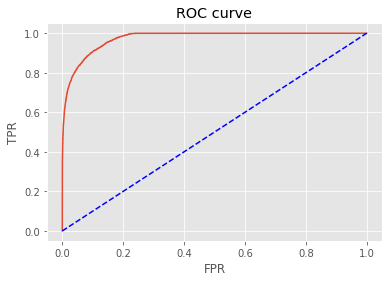

In [ ]:
em.get_auc_metrics(y_test_score)

In [ ]:
top_features = em.get_feature_importance()

In [ ]:
top_features

entry_channel_Unknown    0.458656
cluster                  0.287369
active_customer          0.068581
entry_channel_KHE        0.067292
entry_year               0.020819
entry_day                0.017702
age                      0.014526
entry_week               0.010676
region_code              0.009612
entry_channel_KHM        0.009533
entry_channel_KHQ        0.008066
entry_channel_KHK        0.007157
entry_channel_KHN        0.004319
entry_channel_KFC        0.003696
gender                   0.003401
salary                   0.003249
entry_channel_Others     0.002848
entry_weekday            0.002499
entry_channel_KAT        0.000000
country_id               0.000000
dtype: float32

In [ ]:
# revisar el overfitting
for i in range(1, 14):
    em = Model("em_acount", max_depth=i, min_samples_leaf=150)
    em.load_train_test()
    em.train()
    
    train_accuracy = em.model.score(em.X_train, em.y_train)
    test_accuracy = em.model.score(em.X_test, em.y_test)
    print('Profundidad del árbol: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))

Profundidad del árbol: 1. Train: 0.9484364114489809 - Test: 0.9469285894177714
Profundidad del árbol: 2. Train: 0.9541177278659249 - Test: 0.9533850768138837
Profundidad del árbol: 3. Train: 0.9558643156417729 - Test: 0.9551480184078577
Profundidad del árbol: 4. Train: 0.956256807276795 - Test: 0.9551022277171051
Profundidad del árbol: 5. Train: 0.9576109034176209 - Test: 0.9558806694598988
Profundidad del árbol: 6. Train: 0.9591121839215802 - Test: 0.9567964832749501
Profundidad del árbol: 7. Train: 0.9609863314788104 - Test: 0.956704901893445
Profundidad del árbol: 8. Train: 0.96400851706848 - Test: 0.9567506925841976
Profundidad del árbol: 9. Train: 0.9669914534946474 - Test: 0.955903564805275
Profundidad del árbol: 10. Train: 0.9713481106433919 - Test: 0.9560409368775328
Profundidad del árbol: 11. Train: 0.9751945286666078 - Test: 0.9561325182590379
Profundidad del árbol: 12. Train: 0.9792568170890857 - Test: 0.9561325182590379
Profundidad del árbol: 13. Train: 0.9832602317663105 -

Podemos observar como la profundidad de árbol óptima para el modelo son 8 cortes. Para profundidades superiores, ya entramos en overfitting. 

Para relizar la optimitzación de hipermatametros se ha decidio no utilizar tècnicas más avanzadas como puede ser GridSearch por motivos de ineficiencia. Por este motivo para todos los modelos se irá modificando únicamente la profundidad de los distintos àrboles, recurriedo a metodos de poda para el control del overfitting. 

## MODEL 2: cuentas

In [ ]:
cuentas = Model("cuentas", max_depth=4, min_samples_leaf=150)
cuentas.load_train_test()
cuentas.train()
y_test_pred = pd.DataFrame(cuentas.predict(), index=cuentas.y_test.index, columns=["PrediccionCompra"])
y_test_score = pd.DataFrame(cuentas.predict_proba(), index=cuentas.y_test.index, columns=["CompraScore"])

In [ ]:
results_df = cuentas.y_test.join(y_test_pred, how= 'inner')
results_df["Success"] = (results_df["compra"] == results_df["PrediccionCompra"]).astype(int)
results_df = results_df.join(y_test_score)

In [ ]:
cuentas.get_metrics(y_test_pred)

Accuracy Score : 0.9517468688200396
Precision Score : 0.7673913043478261
Recall Score : 0.7204081632653061
F1 Score : 0.7431578947368421


In [ ]:
cuentas.confusion_matrix(results_df["compra"], results_df["PrediccionCompra"])

PrediccionCompra,0.0,1.0
compra,,
0.0,40137,963
1.0,1233,3177


AUC : 0.97644676719025


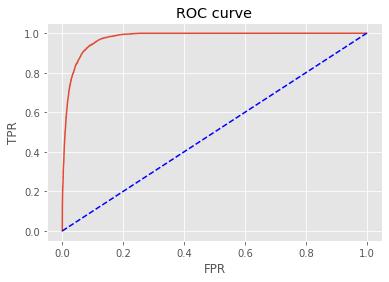

In [ ]:
cuentas.get_auc_metrics(y_test_score)

In [ ]:
top_features = cuentas.get_feature_importance()
top_features

entry_channel_Unknown    0.662219
cluster                  0.167557
active_customer          0.078738
entry_channel_KHE        0.038485
entry_year               0.007399
entry_channel_KHQ        0.005501
entry_channel_KHK        0.004067
entry_channel_KHM        0.003769
entry_week               0.003535
age                      0.003459
entry_channel_KFC        0.003190
salary                   0.003186
entry_channel_KAT        0.002934
entry_channel_Others     0.002895
entry_day                0.002890
region_code              0.002842
entry_weekday            0.002468
entry_channel_KHN        0.002468
gender                   0.002399
country_id               0.000000
dtype: float32

In [ ]:
for i in range(1, 14):
    cuentas = Model("cuentas", max_depth=i, min_samples_leaf=150)
    cuentas.load_train_test()
    cuentas.train()
    train_accuracy = cuentas.model.score(cuentas.X_train, cuentas.y_train)
    test_accuracy = cuentas.model.score(cuentas.X_test, cuentas.y_test)
    print('Profundidad del árbol: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))

Profundidad del árbol: 1. Train: 0.9452208305866843 - Test: 0.9457042408261921
Profundidad del árbol: 2. Train: 0.9478105282983331 - Test: 0.9482531311799605
Profundidad del árbol: 3. Train: 0.950051793954233 - Test: 0.9504284772577456
Profundidad del árbol: 4. Train: 0.9520482154628496 - Test: 0.9517468688200396
Profundidad del árbol: 5. Train: 0.9529334212261041 - Test: 0.9524500109865963
Profundidad del árbol: 6. Train: 0.9546190790093229 - Test: 0.9529993408042189
Profundidad del árbol: 7. Train: 0.9569733496562765 - Test: 0.9528015820698748
Profundidad del árbol: 8. Train: 0.9607119314436388 - Test: 0.9526257965282355
Profundidad del árbol: 9. Train: 0.9650249552688577 - Test: 0.9524719841793012
Profundidad del árbol: 10. Train: 0.9702514361050947 - Test: 0.9520764667106131
Profundidad del árbol: 11. Train: 0.9757510123363782 - Test: 0.9506921555702044
Profundidad del árbol: 12. Train: 0.9813447593935399 - Test: 0.9508899143045485
Profundidad del árbol: 13. Train: 0.98610038610038

Observamos que la profundidad optima es de 6 cortes.

### MODEL 3:  ahorro_inversion

In [ ]:
ah_inv = Model("ahorro_inversion", max_depth=4, min_samples_leaf=150)
ah_inv.load_train_test()
ah_inv.train()
y_test_pred = pd.DataFrame(ah_inv.predict(), index=ah_inv.y_test.index, columns=["PrediccionCompra"])
y_test_score = pd.DataFrame(ah_inv.predict_proba(), index=ah_inv.y_test.index, columns=["CompraScore"])

In [ ]:
results_df = ah_inv.y_test.join(y_test_pred, how= 'inner')
results_df["Success"] = (results_df["compra"] == results_df["PrediccionCompra"]).astype(int)
results_df = results_df.join(y_test_score)

In [ ]:
ah_inv.get_metrics(y_test_pred)

Accuracy Score : 0.9453572208870439
Precision Score : 0.7454448017148981
Recall Score : 0.6420493884144934
F1 Score : 0.6898946063236205


In [ ]:
ah_inv.confusion_matrix(results_df["compra"], results_df["PrediccionCompra"])

PrediccionCompra,0.0,1.0
compra,,
0.0,40487,950
1.0,1551,2782


AUC : 0.9653415701660963


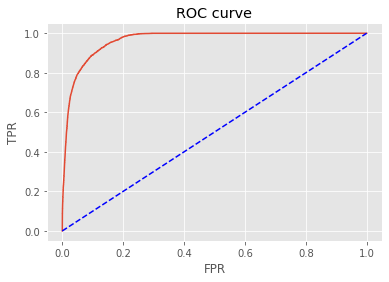

In [ ]:
ah_inv.get_auc_metrics(y_test_score)

In [ ]:
top_features = ah_inv.get_feature_importance()

In [ ]:
for i in range(1, 14):
    ah_inv= Model("ahorro_inversion", max_depth=i, min_samples_leaf=150)
    ah_inv.load_train_test()
    ah_inv.train()
    train_accuracy = ah_inv.model.score(ah_inv.X_train, ah_inv.y_train)
    test_accuracy = ah_inv.model.score(ah_inv.X_test, ah_inv.y_test)
    print('Profundidad del árbol: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))

Profundidad del árbol: 1. Train: 0.9403722985879621 - Test: 0.9392833733886825
Profundidad del árbol: 2. Train: 0.9426944829394359 - Test: 0.9427354162114923
Profundidad del árbol: 3. Train: 0.9451477583430091 - Test: 0.9446143762289709
Profundidad del árbol: 4. Train: 0.9459530319487621 - Test: 0.9453572208870439
Profundidad del árbol: 5. Train: 0.9473763062286977 - Test: 0.9458378850775617
Profundidad del árbol: 6. Train: 0.9486403985167984 - Test: 0.9460345204282281
Profundidad del árbol: 7. Train: 0.9510562193340575 - Test: 0.9459908236836355
Profundidad del árbol: 8. Train: 0.9541930409378628 - Test: 0.9460126720559319
Profundidad del árbol: 9. Train: 0.9593149556163152 - Test: 0.945532007865414
Profundidad del árbol: 10. Train: 0.9650267800292146 - Test: 0.9445925278566747
Profundidad del árbol: 11. Train: 0.9704764223379153 - Test: 0.9440244701769718
Profundidad del árbol: 12. Train: 0.9769373384770965 - Test: 0.9434345641249727
Profundidad del árbol: 13. Train: 0.98209670774186

La profunidad optima se da en max_depth=6.


## MODEL 4: debit_card

In [ ]:
debit = Model("debit_card", max_depth=4, min_samples_leaf=150)
debit.load_train_test()
debit.train()
y_test_pred = pd.DataFrame(debit.predict(), index=debit.y_test.index, columns=["PrediccionCompra"])
y_test_score = pd.DataFrame(debit.predict_proba(), index=debit.y_test.index, columns=["CompraScore"])

In [ ]:
results_df = debit.y_test.join(y_test_pred, how= 'inner')
results_df["Success"] = (results_df["compra"] == results_df["PrediccionCompra"]).astype(int)
results_df = results_df.join(y_test_score)

In [ ]:
debit.get_metrics(y_test_pred)

Accuracy Score : 0.9239958805355304
Precision Score : 0.6931464174454829
Recall Score : 0.4513184584178499
F1 Score : 0.5466830466830468


In [ ]:
debit.confusion_matrix(results_df["compra"], results_df["PrediccionCompra"])

PrediccionCompra,0.0,1.0
compra,,
0.0,42635,985
1.0,2705,2225


AUC : 0.9542799676907239


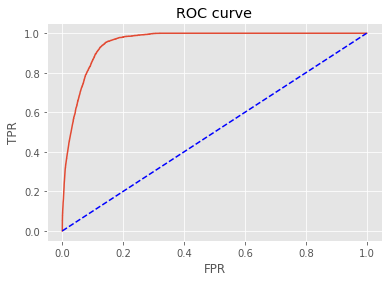

In [ ]:
debit.get_auc_metrics(y_test_score)

In [ ]:
top_features = debit.get_feature_importance()

In [ ]:
top_features

entry_channel_Unknown    0.662219
cluster                  0.167557
active_customer          0.078738
entry_channel_KHE        0.038485
entry_year               0.007399
entry_channel_KHQ        0.005501
entry_channel_KHK        0.004067
entry_channel_KHM        0.003769
entry_week               0.003535
age                      0.003459
entry_channel_KFC        0.003190
salary                   0.003186
entry_channel_KAT        0.002934
entry_channel_Others     0.002895
entry_day                0.002890
region_code              0.002842
entry_weekday            0.002468
entry_channel_KHN        0.002468
gender                   0.002399
country_id               0.000000
dtype: float32

In [ ]:
# revisar el overfitting
for i in range(1, 14):
    debit = Model("debit_card", max_depth=i, min_samples_leaf=150)
    debit.load_train_test()
    debit.train()
    train_accuracy = debit.model.score(debit.X_train, debit.y_train)
    test_accuracy = debit.model.score(debit.X_test, debit.y_test)
    print('Profundidad del árbol: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))

Profundidad del árbol: 1. Train: 0.9158111245486886 - Test: 0.9140473738414007
Profundidad del árbol: 2. Train: 0.9210812051447286 - Test: 0.92
Profundidad del árbol: 3. Train: 0.9242767984039689 - Test: 0.9225334706488156
Profundidad del árbol: 4. Train: 0.92634245813508 - Test: 0.9239958805355304
Profundidad del árbol: 5. Train: 0.9280550136386508 - Test: 0.9245108135942327
Profundidad del árbol: 6. Train: 0.9303943291461056 - Test: 0.9253553038105047
Profundidad del árbol: 7. Train: 0.933607577616723 - Test: 0.9246549948506694
Profundidad del árbol: 8. Train: 0.9388246925786319 - Test: 0.9246343975283213
Profundidad del árbol: 9. Train: 0.9460545016375208 - Test: 0.9237899073120495
Profundidad del árbol: 10. Train: 0.9545466583098666 - Test: 0.9233985581874357
Profundidad del árbol: 11. Train: 0.9641687485103415 - Test: 0.9219773429454171
Profundidad del árbol: 12. Train: 0.9734112516662106 - Test: 0.92086508753862
Profundidad del árbol: 13. Train: 0.9823977542571128 - Test: 0.92039

La profunidad optima se da en max_depth=6.

### MODEL 5: financiacion

In [ ]:
fin = Model("financiacion", max_depth=4, min_samples_leaf=150)
fin.load_train_test()
fin.train()
y_test_pred = pd.DataFrame(fin.predict(), index=fin.y_test.index, columns=["PrediccionCompra"])
y_test_score = pd.DataFrame(fin.predict_proba(), index=fin.y_test.index, columns=["CompraScore"])

In [ ]:
results_df = fin.y_test.join(y_test_pred, how= 'inner')
results_df["Success"] = (results_df["compra"] == results_df["PrediccionCompra"]).astype(int)
results_df = results_df.join(y_test_score)

In [ ]:
fin.get_metrics(y_test_pred)

Accuracy Score : 0.9323616335303601
Precision Score : 0.9063136456211812
Recall Score : 0.31650071123755336
F1 Score : 0.4691618344754876


In [ ]:
fin.confusion_matrix(results_df["compra"], results_df["PrediccionCompra"])

PrediccionCompra,0.0,1.0
compra,,
0.0,13436,46
1.0,961,445


AUC : 0.9014748709780683


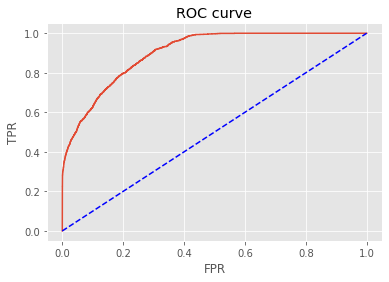

In [ ]:
fin.get_auc_metrics(y_test_score)

In [ ]:
top_features = fin.get_feature_importance()

In [ ]:
top_features

entry_channel_Unknown    0.662219
cluster                  0.167557
active_customer          0.078738
entry_channel_KHE        0.038485
entry_year               0.007399
entry_channel_KHQ        0.005501
entry_channel_KHK        0.004067
entry_channel_KHM        0.003769
entry_week               0.003535
age                      0.003459
entry_channel_KFC        0.003190
salary                   0.003186
entry_channel_KAT        0.002934
entry_channel_Others     0.002895
entry_day                0.002890
region_code              0.002842
entry_weekday            0.002468
entry_channel_KHN        0.002468
gender                   0.002399
country_id               0.000000
dtype: float32

In [ ]:
# revisar el overfitting
for i in range(1, 14):
    fin = Model("financiacion", max_depth=i, min_samples_leaf=150)
    fin.load_train_test()
    fin.train()
    train_accuracy = fin.model.score(fin.X_train, fin.y_train)
    test_accuracy = fin.model.score(fin.X_test, fin.y_test)
    print('Profundidad del árbol: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))

Profundidad del árbol: 1. Train: 0.9311109191927915 - Test: 0.9294734013970983
Profundidad del árbol: 2. Train: 0.9335578777672223 - Test: 0.9316899516389038
Profundidad del árbol: 3. Train: 0.9340184817341739 - Test: 0.9325631380977969
Profundidad del árbol: 4. Train: 0.9352563548953565 - Test: 0.9323616335303601
Profundidad del árbol: 5. Train: 0.936724530040015 - Test: 0.9333019881783987
Profundidad del árbol: 6. Train: 0.937933615453263 - Test: 0.932898979043525
Profundidad del árbol: 7. Train: 0.9396033048334629 - Test: 0.932898979043525
Profundidad del árbol: 8. Train: 0.9427411693583211 - Test: 0.9323616335303601
Profundidad del árbol: 9. Train: 0.9476350865071825 - Test: 0.9322272971520688
Profundidad del árbol: 10. Train: 0.9548320234908023 - Test: 0.9318242880171951
Profundidad del árbol: 11. Train: 0.9614532055157325 - Test: 0.9310182697474476
Profundidad del árbol: 12. Train: 0.9706652848547658 - Test: 0.9311526061257388
Profundidad del árbol: 13. Train: 0.9816622045657368 

La profundiad del árbol optima se da en max_depth=5.

# Save Models

Guardamos los 5 modelos con sus hiperparametros optimitzados. 

In [ ]:
models={'em_acount':8,'cuentas':6,'ahorro_inversion':6,'debit_card':7,'financiacion':5}
models_list=[Model(key, max_depth=value, min_samples_leaf=150) for key, value in models.items()]

In [ ]:
for model in models_list:
  model.save_model()

In [ ]:
def evaluacion_final(model,val_df_X,val_df_y,target):

    y_val_pred=pd.DataFrame(model.predict(val_df_X),index=val_df_y.index,columns=['Compra_Prediction'])
    result_df=val_df_y.join(y_val_pred)
    result_df['Success']=(result_df[target]==result_df['Compra_Prediction']).astype(int)
    y_score=pd.DataFrame(model.predict_proba(val_df_X)[:,1],index=val_df_y.index,columns=['Compra_Score'])
    result_df.join(y_score) 
    #confusion_matrix = pd.crosstab(result_df[target], result_df['Compra_Prediction'])

    print('AUC del dataset de validacion para el modelo {} és = {}'.format(target,metrics.roc_auc_score(val_df_y,y_score)))
          
    return result_df
  



In [ ]:
d_results={}
for model, target in zip(models_list,models.keys()):
  dev_X,dev_y, val_df_X, val_df_y =load_datasets(target)
  print(val_df_y)
  d_results[target]=evaluacion_final(model,val_df_X,val_df_y,target)

        compra
145590     1.0
145591     1.0
145592     1.0
145593     1.0
145594     1.0
...        ...
149281     0.0
149282     0.0
149283     0.0
149284     0.0
149285     0.0

[3696 rows x 1 columns]


TypeError: ignored

In [ ]:
# optimizar el modelo(mejores parámetros) 
# no hace falta GridSearchCV = ineficiente, comentar sus limitaciones
# jugar con profundidad en caso de overfitting para optimizar

In [ ]:
# bootstrap para los productos de financiacion (en caso de que su modelo tenga mala perfrmance)
# o probar kfold 
# kf = model_selection.KFold(n_splits=10, random_state=RANDOM_STATE, shuffle=False)


In [ ]:
# guardar graphviz para ponerlo en el informe y presentación

In [ ]:
# TODO meter el beneficio por producto que nos aporta el cliente (una vez tengamos los distintos modelos ya hechos) 
# y hayamos sacado la lista de clientes
# Tendremos que coger los 1666 (10e3 // 6) clientes con mejor scoring de cada modelo 
# o coger más de los que más beneficio nos aporte